# Intelligence Amplification in Finance
Lately I have attended a few "Artificial Intelligence in Finance" conferences (one given by [RavenPack](https://www.ravenpack.com/event/big-data-machine-learning-revolution-london/), the other a private Angel Event). 

There was a lot of debate about the applicability of AI in Finance, but most of the time arguments in favour and against were directed to specific algorithms and applications - see the presenttions in the link above.

Inspired by the event, I developed the following example to highlight some of the challenges about Artificial Intelligence (AI) (or Artificial Narrow Intelligence -ANI-, Intelligence Amplification -IA- or any new trending acronym). As usual, I use open source data and code and a working google colaboratory [notebook](https://drive.google.com/file/d/1uJDJIdt-kRAwZ3NLmSl4e97ct_9FXCvD/view?usp=sharing).

## Regime change identification for Rates

Rates traders usually have an arsenal of strategies (steepener, flattener, butterflies) that they deploy depending on the current 'regime' (whether the Central Bank is easying or tightening - see ["Yield Curve Spread Trades"](https://www.cmegroup.com/education/files/yield-curve-spread-trades.pdf)).

To identify the regimes, Financial Analysts usually scatter plot different financial signals and then plot the Time Series (for example, open "[Are the markets overpricring a Le Pen victory ? ](https://drive.google.com/open?id=1SEbOM9TSKy3VMrrJMIMDpKaXuBRcspG6)" - in page 4 you will see the spreads clustered in nice blobs labeled according to different market regimes.

The following is a quick example to automatically do a similar job (but using public data).

I start by loading all the required libraries, and defining helpful functions. For further details regarding clustering algorithms please read ["Comparing Clustering Algorithms"](http://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html).


In [42]:
# -*- coding: utf-8 -*-
# Import all required libraries
# Request: allow HTTP-post API calls
import requests
# Json: to format as json calls to API
import json 
# Pandas: to plot the timeseries
import pandas as pd
# Datetime: to convert different date formats
import datetime as dt
# Import the Time Series library
import statsmodels.tsa.stattools as ts
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster
import time
#%matplotlib inline
!pip install hdbscan
import hdbscan

sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}


def plot_clusters(data, algorithm, args, kwds):
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time.time()
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    #plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)
    return labels, palette



Looking in indexes: https://pypi.org/simple, https://legacy.pypi.org/simple


### Data Downloading and processing

Unfortunately I cannot repeat the manual process I used for the European Rates manual example above (as the underlying data is proprietary), but we can download data from Quandl:

['Date', '1 MO', '3 MO', '6 MO', '1 YR', '2 YR', '3 YR', '5 YR', '7 YR', '10 YR', '20 YR', '30 YR']


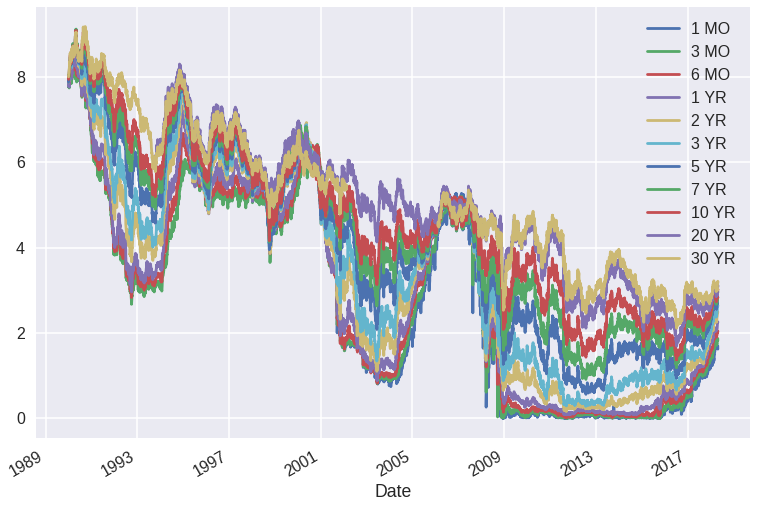

In [43]:



# Treasury rates
QUAND_TS = "https://www.quandl.com/api/v3/datasets/USTREASURY/YIELD.json?api_key=o6YKGjyDcseE3LFKrSK3"
#cols = [5, 7, 9, 10]
cols = [5, 7, 9, 10]


# Call Quandl to get all the data
q = requests.get(url = QUAND_TS)
q_json = q.json() 
q_data = q_json['dataset']['data']

# Compute derived series from Quandl Data
dates = []
values = []
q_len = len(q_data)
column_len = len(q_data[0])
column = column_len-1
columns = q_json['dataset']['column_names']
print (columns)


# The following could be easily done using Quandl's
# python API - but I keep it the 'hard way' to allow
# compatibility with Google Colaboratory
df_rates = pd.DataFrame.from_records(q_data, columns = columns)
df_rates['Date'] = pd.to_datetime(df_rates['Date'])
df_rates.set_index('Date', inplace=True)
df_rates.plot()

columns_fly = [columns[i] for i in cols]
TimeSeries = df_rates[columns_fly]
TS = TimeSeries - TimeSeries.mean()




### Dimensionality Reduction

Once we have the data in our hands, we start applying some initial AI techniques - above we show the whole term structure, but usually data could be preprocessed to reduce the number of features that we analyse. See this lecture from the [Stanford Machine Learning class](https://www.coursera.org/learn/machine-learning/lecture/ZYIPa/principal-component-analysis-algorithm), but it is worthwhile to point out that the Fixed Income analysts have known about PCA for years ([Principal Component Analysis for Yield Curve Modelling](https://)) with the common factoid:


> "This means that it might be appropriate to use two PCs in a reduced model as these should cover
around 99% of the yield curve variability."

The magic of python and the above libraries, is that we can get the dimensionality reduction by running just a few lines of code:



In [0]:

TS = TimeSeries.dropna()
data_array = (TS.dropna()).as_matrix()

# n components = 2 from the above analysis, BUT it can be derived
# from the data
pca = PCA(n_components=2).fit(data_array)
pca_2d = pca.transform(data_array)


The other reason I stick to 2 reduced dimensions is for illustration purposes - I can just scatter plot the principal components to visually looks at the possible blobs.

### Clusterization

#### K-means
For the first example I pick [K-means](https://en.wikipedia.org/wiki/K-means_clustering) because:


*   It is the simplest algorithm - given the number of clusters it partitions the space such that each observation belongs to the cluster with the nearest mean. 
*   It illustrates the first shortcoming - a human needs to decide how many clusters (I entered 6)
*   Some clusters do not fit with our human perception (the red cluster takes data from the top and bottom data points) 




(array([3, 3, 3, ..., 1, 1, 1], dtype=int32),
 [(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
  (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
  (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
  (0.5058823529411764, 0.4470588235294118, 0.6980392156862745),
  (0.8, 0.7254901960784313, 0.4549019607843137),
  (0.39215686274509803, 0.7098039215686275, 0.803921568627451)])

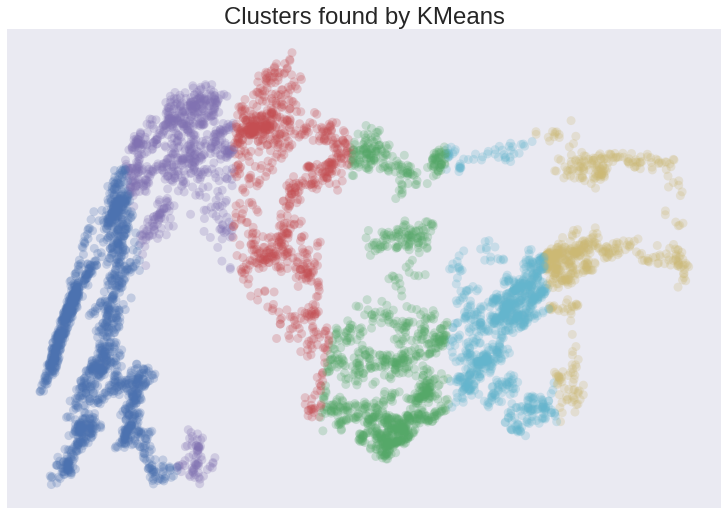

In [45]:
data = pca_2d.copy()    

plot_clusters(data, cluster.KMeans, (), {'n_clusters':6})


#### HDBSSCAN

For the second example, I jump straight to the latest state of the art (in open Source: [HDBSCAN](http://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html)).

An explanation of *how* it works is beyond this blog, but:



*   The parameters required for the human are simpler - instead of providing how many clusters do I need, I enter the minimum amount of data points. For this example I chose 21 (for a month of business days - but try changing to 31 - roughly the number of business days between Fed meetings)
*   The clusters look more 'natural' to the human eye - just like the ones I manually selected in the Le Pen example mentioned at the beginning.



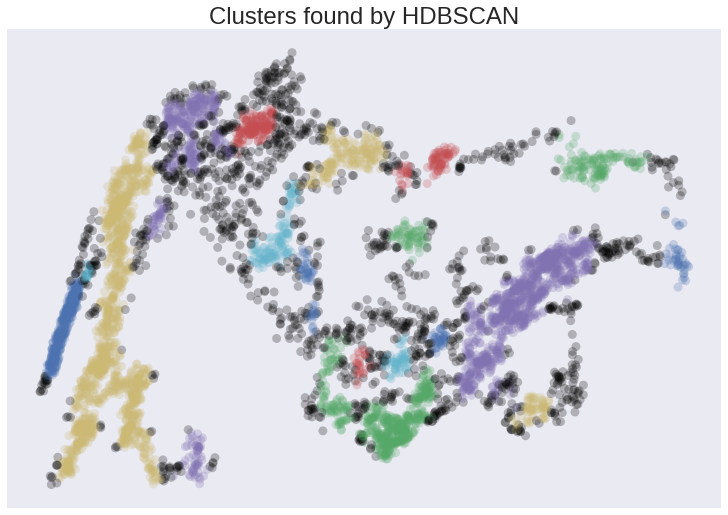

In [46]:

    
TS.is_copy = False
TS['clusters'], colors = plot_clusters(data, hdbscan.HDBSCAN, (), {'min_cluster_size':21})     
cluster_labels = set(TS['clusters'])


Lets return the data to the Time Series space. 

I plot the same colours below for each cluster, and I select the 2 year rate (blue continuous line) and the 10 year rate (clustered line) as examples:

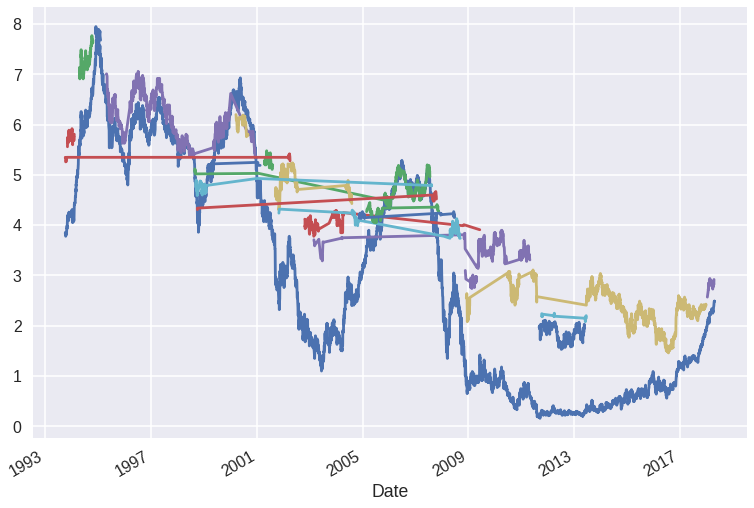

In [48]:
fig,ax=plt.subplots()
TS[['2 YR']].plot(ax = ax, style ='-')


import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0, 1, 10)
number = len(cluster_labels)
top_clusters = number
number = top_clusters
cmap = plt.get_cmap('gnuplot')

cluster_freq = np.unique(TS['clusters'], return_counts=True)
df_cf_t = pd.DataFrame([cluster_freq[0],cluster_freq[1]])
df_cf = (df_cf_t.transpose()).sort_values([1],ascending = False) 
i = 0
#for cluster_label in cluster_labels:
for i in range(0,top_clusters):
    cluster_label = df_cf.iloc[i][0]
    if (cluster_label >= 0):
#        TS[['10 YR']][TS['clusters'] == cluster_label].plot(ax = ax, style =':', color = colors[cluster_label])
        TS[['10 YR']][TS['clusters'] == cluster_label].plot(ax = ax, color = colors[cluster_label])
 
        ax.legend_.remove()




Because the algorithm found many more clusters than available colours, it is important to notice that each cluster will connect all the points.

A few interesting observations:

* Some of the clusters take data from different time periods, so we need to remember: our analysis removed the time dimension from the data, so this behaviour could be fixed by adding it back (wait for the next analysis )
* On the other hand, the regimes do look like they correspond to the Fed regimes (more to follow) - which is quite interesting - all the code really needed for this analysis was the minimum number of data points per cluster (while I forced PCA to be select only 2 factors, we could have added the variance threshold - my decision was to keep the images as 2d)
* From a financial perspective, after the flattening regime from 2014-2017 we have entered a new one (so is this the end of the flattener ?).
* This technique does show that regimes could be identified automatically, which allows traders to 'select their strategy'.






